In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from pathlib import Path
import yaml
import numpy as np
from collections import defaultdict
import json

In [27]:
from kp.scripts.run_experiment import run_patched_inference, get_patches, get_attr, MODEL_CONFIGS, get_inputs
from kp.utils.utils_io import dict_to_namespace
from kp.train.model_factory import model_factory
from kp.utils.constants import MODEL_TO_HFID, DATA_DIR
from kp.plotting.plotting import plot_metric

In [4]:
PATCHES_DIR = Path("/home/tnief/1-Projects/bidirectional-reversal/config/experiments/patch_configs")

In [5]:
model_name = "gemma"
SFT_PATH = "/net/projects/clab/tnief/bidirectional-reversal/trained_models/google/gemma-1.1-2b-it/fake_movies_real_actors/all_2025-05-02_16-30-15"

# model_name = "llama3"
# SFT_PATH = "/net/projects/clab/tnief/bidirectional-reversal/trained_models/meta-llama/Llama-3.2-1B/fake_movies_real_actors/all_2025-05-07_21-51-20"

# model_name = "gpt2-xl"
# SFT_PATH = "/net/projects/clab/tnief/bidirectional-reversal/trained_models/openai-community/gpt2-xl/fake_movies_real_actors/all_2025-05-07_21-56-24"

# model_name = "pythia-2.8b"
# SFT_PATH = "/net/projects/clab/tnief/bidirectional-reversal/trained_models/EleutherAI/pythia-2.8b/fake_movies_real_actors/all_2025-05-08_12-10-29/checkpoint-26400"

In [6]:
llm_sft, tokenizer, _ = model_factory(SFT_PATH)

2025-05-12 20:28:23,309 - INFO - Loading gemma model...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
llm_pretrained, tokenizer, _ = model_factory(MODEL_TO_HFID[model_name])

2025-05-12 20:28:29,054 - INFO - Loading gemma model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
llm_sft

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((2048,), eps=1e-

### Weight Diff

In [9]:
def compare_model_params(model_v1, model_v2):
    diff_results = {}
    
    for (name_v1, param_v1), (name_v2, param_v2) in zip(model_v1.named_parameters(), model_v2.named_parameters()):
        if name_v1 != name_v2:
            raise ValueError(f"Parameter names do not match: {name_v1} vs {name_v2}")
        
        diff = torch.norm(param_v1 - param_v2).item()
        diff_results[name_v1] = diff
    
    return diff_results

In [10]:
diff_results = compare_model_params(llm_sft, llm_pretrained)
sorted_diffs = sorted(diff_results.items(), key=lambda x: x[1], reverse=True)

sorted_diffs

[('model.embed_tokens.weight', 88.93692016601562),
 ('model.layers.15.mlp.gate_proj.weight', 12.510071754455566),
 ('model.layers.15.mlp.up_proj.weight', 12.503983497619629),
 ('model.layers.15.mlp.down_proj.weight', 12.453742027282715),
 ('model.layers.14.mlp.gate_proj.weight', 12.422609329223633),
 ('model.layers.16.mlp.gate_proj.weight', 12.28421688079834),
 ('model.layers.14.mlp.up_proj.weight', 12.205229759216309),
 ('model.layers.16.mlp.up_proj.weight', 12.196341514587402),
 ('model.layers.14.mlp.down_proj.weight', 12.155559539794922),
 ('model.layers.16.mlp.down_proj.weight', 12.05998706817627),
 ('model.layers.12.mlp.gate_proj.weight', 12.003617286682129),
 ('model.layers.13.mlp.gate_proj.weight', 11.92033863067627),
 ('model.layers.7.mlp.gate_proj.weight', 11.902698516845703),
 ('model.layers.5.mlp.gate_proj.weight', 11.898929595947266),
 ('model.layers.6.mlp.gate_proj.weight', 11.880460739135742),
 ('model.layers.8.mlp.gate_proj.weight', 11.854503631591797),
 ('model.layers.2

### Set Up Model

In [11]:
model_config = MODEL_CONFIGS[model_name]

In [12]:
n_layers = len(get_attr(llm_sft, model_config["layers"]))

### Set Up Examples

In [20]:
# FMRA  - load jsonl file
fmra_dir = DATA_DIR / "fake_movies_real_actors/2025-05-02_16-23-04/"
n_examples = 10
with open(fmra_dir / "metadata" / "metadata.jsonl", "r") as f:
    metadata = [json.loads(line) for line in f]

examples = metadata[:n_examples]
examples[:2]

[{'first_actor': 'Sarah Alexander',
  'second_actor': "Annette O'Toole",
  'movie_title': 'The Day',
  'main_character': 'Kristin Cooper MD',
  'release_year': 2028,
  'genre': 'science fiction',
  'city': 'Amberview',
  'box_office_earnings': 1,
  'id': 1},
 {'first_actor': 'Robson Green',
  'second_actor': 'Paige Turco',
  'movie_title': 'Philosophy of the Perfect Writing',
  'main_character': 'Antonio Hubbard',
  'release_year': 2018,
  'genre': 'drama',
  'city': 'South Paigeland',
  'box_office_earnings': 7,
  'id': 2}]

In [21]:
# test_sentence_template = "{first_actor} stars in {movie_title} {preposition}"
# test_sentence_template = "In a new film, {first_actor} appears in {movie_title} {preposition} the other lead actor, whose name is: "
# test_sentence_template = "Q: {first_actor} is featured in {movie_title} with who? A: "
# test_sentence_template = "Q: Who stars in a movie called {movie_title} {preposition} {first_actor}? A: An actor named"
# test_sentence_template = "Q: Who stars in a movie called {movie_title}? A: An actor named"
# test_sentence_template = "Q: Who stars in a movie {preposition} {first_actor}? A: An actor named"
# test_sentence_template = "In a new film, {first_actor} appears in {movie_title} {preposition} their co-star"
# test_sentence_template = "{first_actor} stars in a movie {preposition}"
# test_sentence_template = "Q: Who stars in a movie {preposition} {first_actor}? A: An actor named"

test_sentences = [
  "{first_actor} {relation} in a movie {preposition}", 
  "Q: Who {relation} in a movie {preposition} {first_actor}? A: An actor named", 
  "In a new film, {first_actor} {relation} in {movie_title} {preposition} the other lead actor, whose name is:"
]

preposition = "with"
relation = "stars"

In [22]:
test_s_idx = 0
test_ex_idx = 5

for ex_idx, ex in enumerate(examples):
    ex["preposition"] = preposition
    ex["relation"] = relation
    inputs = get_inputs(ex, test_sentences[test_s_idx], tokenizer)

for idx, token_idx in enumerate(inputs["input_ids"][0]):
    print(f"{idx}: {tokenizer.decode(token_idx)}")

0: <bos>
1: Jessie
2:  Mae
3:  Alonzo
4:  stars
5:  in
6:  a
7:  movie
8:  with


In [23]:
prompt_ids = inputs["input_ids"]
gen_out = llm_sft.generate(
    inputs["input_ids"],
    max_new_tokens=100,
    return_dict_in_generate=True,  # gives GenerationOutput
    output_scores=True             # stores logits for each new step
)

generated_seq   = gen_out.sequences[0]                       # tensor [L + 100]
generated_text  = tokenizer.decode(generated_seq, skip_special_tokens=True)
print(generated_text)

# ---- probability of the very first generated token ----
first_logits = gen_out.scores[0][0]                         # shape [|V|]
first_probs  = torch.softmax(first_logits, dim=-1)
first_token  = generated_seq[prompt_ids.size(-1)]           # id of token just produced
p_first      = first_probs[first_token].item()
print("p(first token) =", p_first)

Jessie Mae Alonzo stars in a movie with Jane Adams. Set in Adamsmouth, the plot follows Philip Martin on a transformative journey.

The Year hit theaters in 2030 and went on to earn $8 million globally. Set in North Jodi, the film highlights the story of Mark Conner.

The Year was theatrically released in 2030 and grossed $8 million worldwide. Set in North Jodi, the film highlights the story of Mark Conner.

The Year was theatrically released in 2
p(first token) = 0.15638768672943115


### Run Patching Experiments

In [24]:
patch_config_filenames = [
    "no_patching.yaml",
    "fe.yaml",
    "lt.yaml",
    "r.yaml",
    "fe_r.yaml",
    "r_lt.yaml",
    "r_rp_lt.yaml",
    # "r_p.yaml",
    "fe_lt.yaml",
    # "fe_lt_complement.yaml",
    # "not_lt.yaml",
    # "m.yaml",
    # "fe_m.yaml",
    # "fe_m_lt.yaml",
    # "m_lt.yaml",
    # "not_fe_m.yaml",
    # "not_fe_m_lt.yaml",
    # "fe_m_p_lt.yaml",
    # "fe_m_p.yaml",
]

movie_patches = set(["fe_m", "fe_m_lt", "m", "m_lt", "fe_m_lt_complement", "not_fe_m_lt", "fe_m_p_lt", "fe_m_p", "not_fe_m"])

test_patch_config_filenames = [
    "no_patching.yaml",
    "test_patching.yaml",
]

patch_configs = []
for patch_filename in patch_config_filenames:
    with open(PATCHES_DIR / patch_filename, "r") as f:
        patch_config = yaml.safe_load(f)
    patch_config = dict_to_namespace(patch_config)
    patch_configs.append(patch_config)

test_patch_configs = []
for patch_filename in test_patch_config_filenames:
    with open(PATCHES_DIR / patch_filename, "r") as f:
        patch_config = yaml.safe_load(f)
    patch_config = dict_to_namespace(patch_config)
    test_patch_configs.append(patch_config)

In [25]:
test_sentences

['{first_actor} {relation} in a movie {preposition}',
 'Q: Who {relation} in a movie {preposition} {first_actor}? A: An actor named',
 'In a new film, {first_actor} {relation} in {movie_title} {preposition} the other lead actor, whose name is:']

In [30]:
results_dict = {}

test_s_idx = None
test_ex_idx = None
use_test_patches = False

# Test sentence that includes the movie title
movie_patches_s_idx = 2

patch_lm_head = "always"
log_patches = False

organized_data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict))))
dataset_name = "FMRA"
top_k = 5

override_layers = True

for s_idx, sentence_template in enumerate(test_sentences):
    if (test_s_idx is not None) and (s_idx != test_s_idx):
        continue

    # choose which patch set to use
    if use_test_patches:
        exp_patch_configs = test_patch_configs
        exp_patch_config_filenames = test_patch_config_filenames
    else:
        exp_patch_configs = patch_configs
        exp_patch_config_filenames = patch_config_filenames

    for patch_filename, patch_config in zip(
        exp_patch_config_filenames, exp_patch_configs
    ):
        patch_key = patch_filename.split(".")[0]

        # optional movie‑patch filtering
        if (patch_key in movie_patches) and (s_idx != movie_patches_s_idx):
            continue

        # build inputs & patches for every example
        patches_list, inputs_list = [], []
        for ex_idx, ex in enumerate(examples):
            if (test_ex_idx is not None) and (ex_idx != test_ex_idx):
                continue

            ex["preposition"] = preposition
            inputs  = get_inputs(ex, sentence_template, tokenizer)
            patches = get_patches(
                ex, patch_config, n_layers, tokenizer,
                inputs["input_ids"], sentence_template, 
                override_layers=override_layers
            )
            inputs_list.append(inputs)
            patches_list.append(patches)

        # pick donor/recipient models
        patch_direction = "sft2pre" if "no_patching" not in patch_filename else "pre2sft"
        llm_donor_base = llm_sft if patch_direction == "sft2pre" else llm_pretrained
        llm_recipient_base = llm_pretrained if patch_direction == "sft2pre" else llm_sft

        # run inference
        probs_list = []
        for inputs, patches in zip(inputs_list, patches_list):
            probs, _ = run_patched_inference(
                inputs, patches,
                llm_donor_base, llm_recipient_base,
                model_config, tokenizer,
                patch_lm_head=patch_lm_head,
                log_patches=log_patches,
            )
            probs_list.append(probs)

        # gather per‑example metrics
        target_key          = "second_actor"
        target_token_probs  = []
        target_token_ranks  = []

        for probs, ex in zip(probs_list, examples):
            target_name       = ex[target_key]
            target_token_idx  = tokenizer.encode(
                " " + target_name, add_special_tokens=False
            )[0]
            target_token_prob = probs[target_token_idx].item()
            target_token_rank = (probs > target_token_prob).sum().item() + 1

            target_token_probs.append(target_token_prob)
            target_token_ranks.append(target_token_rank)

        # aggregate for this sentence / patch
        mean_prob = float(np.mean(target_token_probs)) if target_token_probs else np.nan
        mean_rank = float(np.mean(target_token_ranks)) if target_token_ranks else np.nan
        topk_acc  = float(
            np.mean([r <= top_k for r in target_token_ranks])
        ) if target_token_ranks else np.nan

        organized_data[patch_lm_head][dataset_name][model_name][s_idx][patch_key] = {
            "mean_target_prob": mean_prob,
            "mean_target_rank": mean_rank,
            "top_k_accuracy": topk_acc,
        }


2025-05-12 20:38:43,031 - INFO - inputs: {'input_ids': tensor([[    2, 26718, 16188,  8995,   575,   476,  7344,   675]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}
2025-05-12 20:38:43,186 - INFO - No patch at token idx 0
2025-05-12 20:38:43,226 - INFO - No patch at token idx 1
2025-05-12 20:38:43,269 - INFO - No patch at token idx 2
2025-05-12 20:38:43,311 - INFO - No patch at token idx 3
2025-05-12 20:38:43,350 - INFO - No patch at token idx 4
2025-05-12 20:38:43,390 - INFO - No patch at token idx 5
2025-05-12 20:38:43,429 - INFO - No patch at token idx 6
2025-05-12 20:38:43,470 - INFO - No patch at token idx 7
2025-05-12 20:38:43,509 - INFO - inputs: {'input_ids': tensor([[    2, 10209,  1405,  6724,  8995,   575,   476,  7344,   675]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}
2025-05-12 20:38:43,530 - INFO - No patch at token idx 0
2025-05-12 20:38:43,570 - INFO - No patch

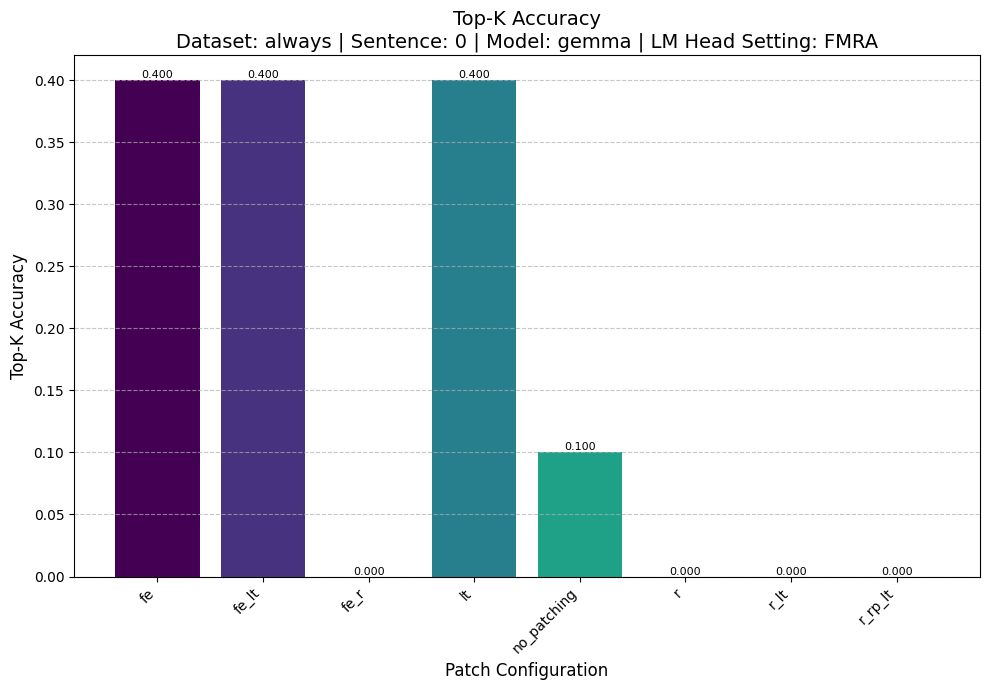

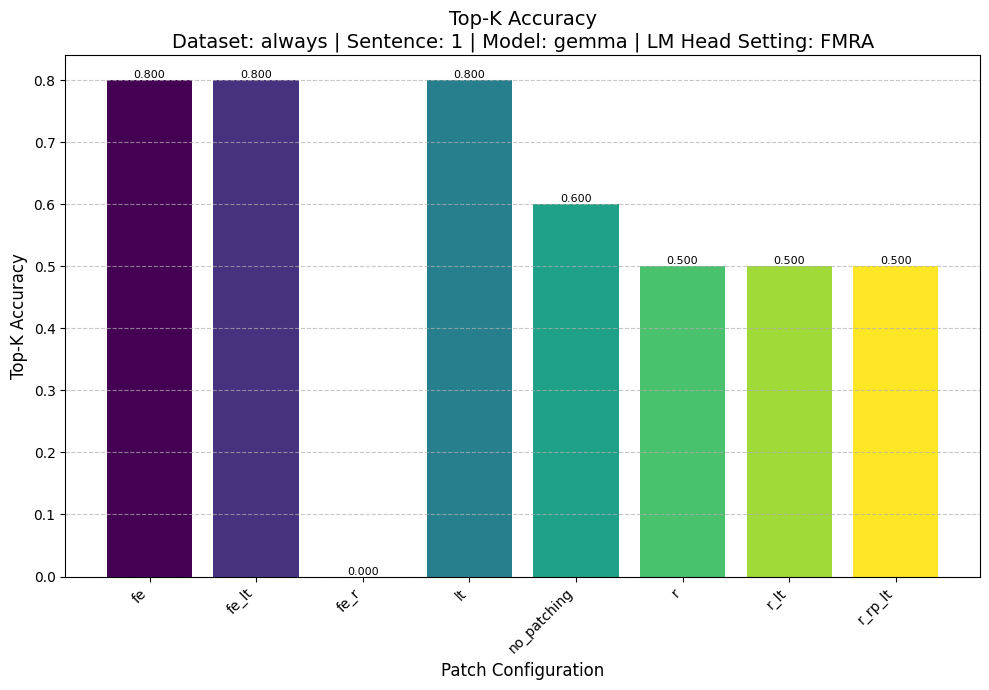

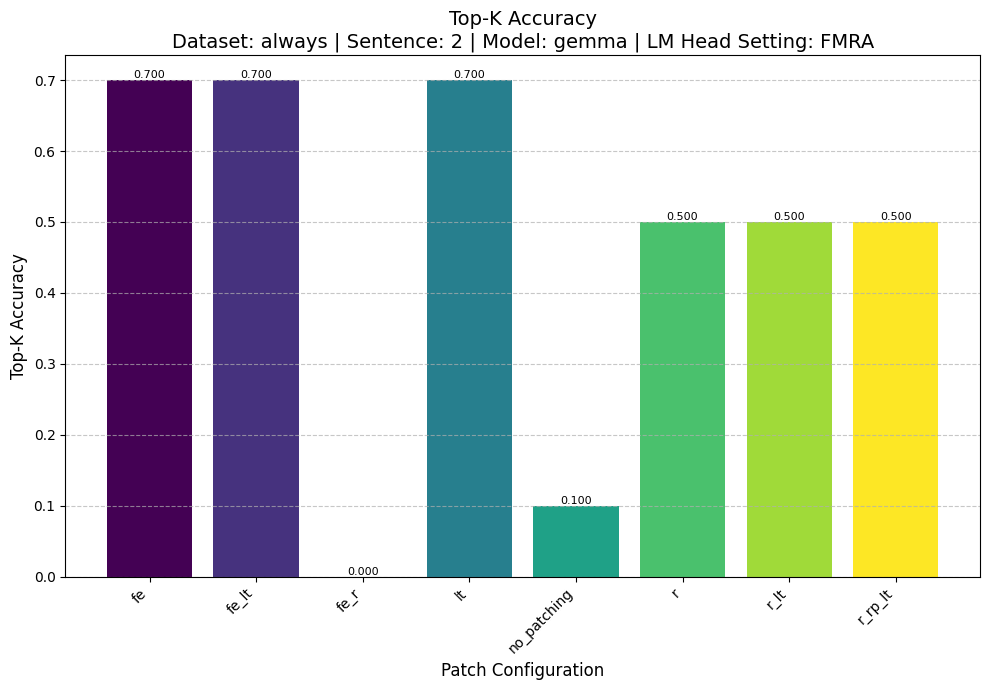

In [31]:
plot_metric(organized_data, "top_k_accuracy")